<div>
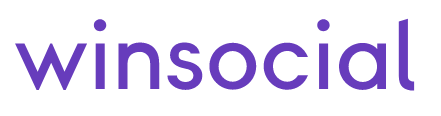
</div>

# Broker Score - Conversão Diária

A próxima evolução do algoritmo de distribuição do projeto MAG Leads visa considerar a conversão diária do corretor: como se posiciona a taxa de conversão do dia em que ele recebe o lead, do dia seguinte ao recebimento do lead, e assim por diante.

Por exemplo, se um corretor recebeu 100 leads em um período e fez:
- 2 vendas no dia 0 (mesmo dia em que recebeu o lead)
- 3 vendas no dia 1 (dia seguinte ao recebimento do lead)
- 1 venda no dia 2 (dois dias após o recebimento do lead)

Sua conversão será, respectivamente:
- 2% no dia 0
- 3% no dia 1
- 1% no dia 2

e assim sucessivamente.

Criaremos um benchmark diário para essa métrica, com base em um modelo desenvolvido a partir de dados históricos e ajustado para o objetivo do projeto. A diferença entre o corretor e o benchmark levará ao score final da conversão diária.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from config import config

In [2]:
plt.style.use('ggplot')

SERVER = config['SERVER']
PORT = config['PORT']
DATABASE = config['DATABASE']
USERNAME = config['USERNAME']
PASSWORD = config['PASSWORD']

Vamos analisar o que já temos em relação ao comportamento mensal da taxa de conversão. O projeto visa atingir uma taxa de conversão de 14% em 2021 no gráfico abaixo:

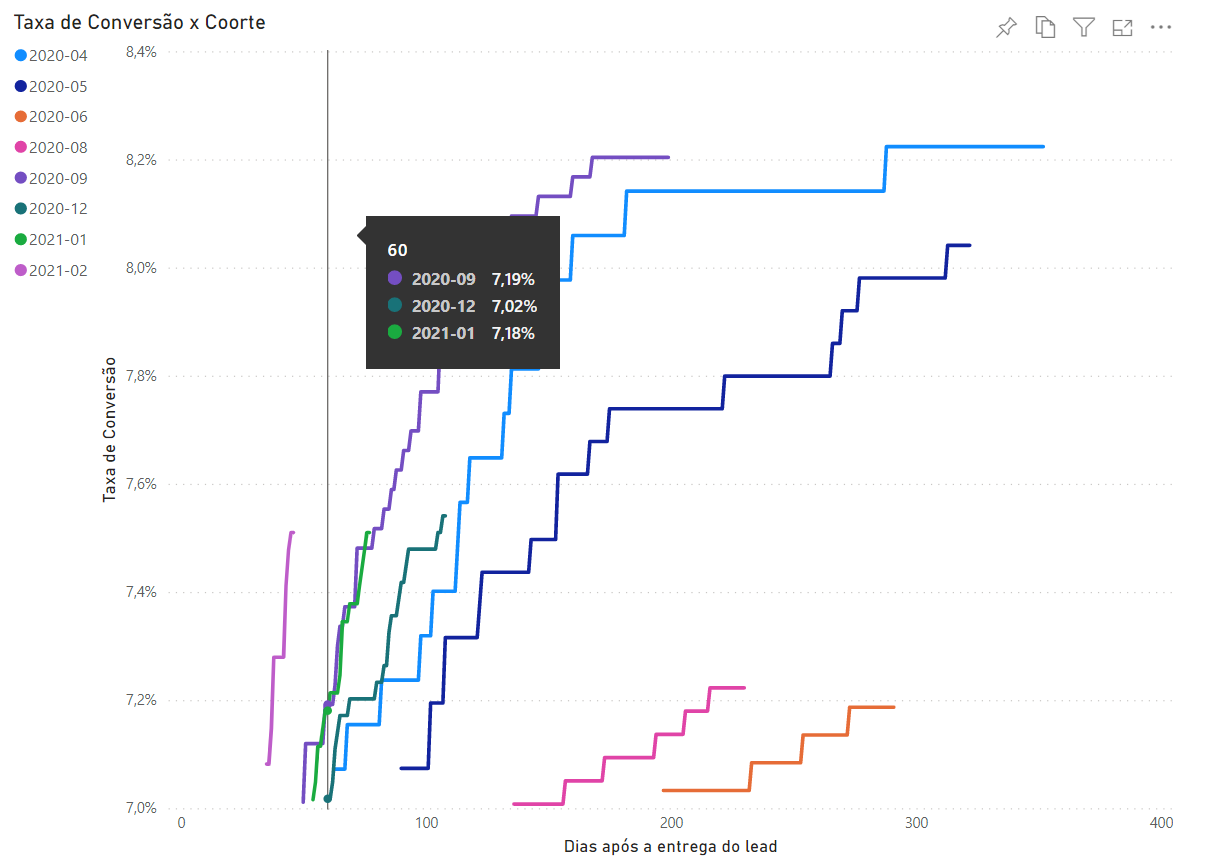

De todos os coortes até Março/21, vemos que 4 deles começam a quebrar a barreira dos 7% por volta do dia 60, dois meses após o início do mês.

Queremos uma taxa ainda maior e não sabemos quando ela irá acontecer.

Para a conversão diária, vamos olhar somente para leads com mais de 180 dias de criação. Dessa forma aumentamos a janela para observação da venda:

In [3]:
MIN_AGE = 180  #Idade mínima do lead

Abaixo vamos ao banco de dados pegar todos os dados necessários:

In [4]:
# Consulta lista de produtores
produtores = """SELECT DISTINCT producer_id FROM leads WHERE producer_id NOT LIKE '11%'
AND DATE(leads.created_at) >= '2020-04-01' AND leads.campaign_id = 1"""

# Descobre a idade das vendas de cada produtor
idades_vendas_produtor = """
SELECT
    producer_id,
    `leads_idades`.`idade_da_venda`,
    COUNT(`leads_idades`.`idade_da_venda`) as `qtdade`
FROM
(
select
    producer_id,
    id,
    DATE(created_at) as `data_da_criacao`,
    qtdade_vendas.`data_da_venda`,
    qtdade_finalizados.`data_da_finalizacao`,
    DATEDIFF(CURRENT_DATE(), created_at) AS `idade_do_lead`,
    DATEDIFF(qtdade_vendas.`data_da_venda`, DATE(created_at)) AS `idade_da_venda`
from leads
left outer join
    (select
        events.lead_id,
        DATE(created_at) as `data_da_venda` from events
    inner join (
        select
            max(id) as `id`,
            lead_id
        from events
        where `type` = 'proposal_created'
        group by lead_id) as `vendas`
        on events.id = `vendas`.id) as `qtdade_vendas`
on leads.id = qtdade_vendas.lead_id
left outer join
    (select
        events.lead_id,
        DATE(events.created_at) as `data_da_finalizacao`
    from events
    inner join (
        select
            max(id) as `id`,
            lead_id
        from events
        where ((`type` = 'updated') AND (`value` ->> '$.status' = 'done'))
        group by lead_id) as `data_finalizacao`
        on events.id = `data_finalizacao`.id) as `qtdade_finalizados`
on leads.id = qtdade_finalizados.lead_id
where campaign_id = 1
and producer_id is not null
and producer_id not like '11%'
and DATE(created_at) >= '2020-04-01'
having `idade_do_lead` >= """ + str(MIN_AGE) + """ AND `idade_da_venda` IS NOT NULL) AS `leads_idades`
GROUP BY producer_id, `leads_idades`.`idade_da_venda`
ORDER BY producer_id
"""

# Consulta o total de leads com cada produtor
leads_produtor = """
SELECT
    producer_id,
    COUNT(id) as `qtdade_leads`
FROM leads
WHERE 
    campaign_id = 1
    and producer_id is not null
    and producer_id not like '11%'
    and DATE(created_at) >= '2020-04-01'
    and DATEDIFF(CURRENT_DATE(), DATE(created_at)) >= """ + str(MIN_AGE) + """
GROUP BY `producer_id`
"""

# Consulta total de leads com mais de 180 dias
total_leads = """
SELECT
    COUNT(`leads_idades`.id) as `qtdade_leads`
FROM
(
select
    id,
    DATEDIFF(CURRENT_DATE(), DATE(created_at)) AS `idade_do_lead`
from leads
where campaign_id = 1
and producer_id is not null
and producer_id not like '11%'
and DATE(created_at) >= '2020-04-01'
having `idade_do_lead` >= """ + str(MIN_AGE) + """) AS `leads_idades`"""

engine = create_engine(
        'mysql+mysqlconnector://' + USERNAME + ':' + PASSWORD + '@' + SERVER + ':25060/' + DATABASE,
        poolclass=NullPool)
conn = engine.connect()
df_idades_vendas_produtor = pd.read_sql(idades_vendas_produtor, conn)
df_leads_produtor = pd.read_sql(leads_produtor, conn)
df_produtores = pd.read_sql(produtores, conn)
df_total_leads = pd.read_sql(total_leads, conn)
conn.close()

Abaixo iniciamos a construção do modelo de dados para nossa análise:

In [5]:
age_range = range(0, MIN_AGE + 1)
produtor_age_range = []

for produtor in df_produtores['producer_id'].to_list():
    for age in age_range:
        item = {'producer_id': produtor, 'age': age}
        produtor_age_range.append(item)

df_produtores_idades = pd.DataFrame(produtor_age_range)
df = pd.merge(df_produtores_idades, df_idades_vendas_produtor,
              left_on=['producer_id', 'age'],
              right_on=['producer_id', 'idade_da_venda'],
              how='left')
df = pd.merge(df, df_leads_produtor,
              on='producer_id',
              how='left')
df['tx_conv'] = df['qtdade'] / df['qtdade_leads']
df['tx_conv'].fillna(0, inplace=True)

Vamos investigar o produtor **7269575**:

In [6]:
broker_sample_leads = df[df['producer_id'] == '7269575']['qtdade_leads'].unique().take(0)
broker_sample_qtdade = df[(df['producer_id'] == '7269575') & (df['idade_da_venda'] == 0)]['qtdade'].values.take(0)
broker_sample_tx_conv = df[(df['producer_id'] == '7269575') & (df['idade_da_venda'] == 0)]['tx_conv'].values.take(0)
df[df['producer_id'] == '7269575'].head()

producer_id  age  idade_da_venda  qtdade  qtdade_leads   tx_conv
1810     7269575    0             0.0     3.0         293.0  0.010239
1811     7269575    1             1.0     5.0         293.0  0.017065
1812     7269575    2             2.0     6.0         293.0  0.020478
1813     7269575    3             3.0     2.0         293.0  0.006826
1814     7269575    4             NaN     NaN         293.0  0.000000

Acima temos um exemplo da modelagem de dados que estamos buscando, já com a taxa de conversão diária calculada. A idade da venda é a diferença em dias entre a data da criação do lead e a data da venda. A quantidade é o número de vendas com aquela idade. A quantidade de leads é o total de leads recebidos pelo corretor

No caso do corretor acima, ele já recebeu **{{round(broker_sample_leads)}}** leads e realizou **{{round(broker_sample_qtdade)}}** vendas no mesmo dia em que recebeu o lead. Sua taxa de conversão do dia 0 é de **{{'{:.1%}'.format(broker_sample_tx_conv)}}**.

## Criação do benchmark

No gráfico abaixo podemos visualizar a quantidade de vendas em relação a idade da venda em nossa amostra.

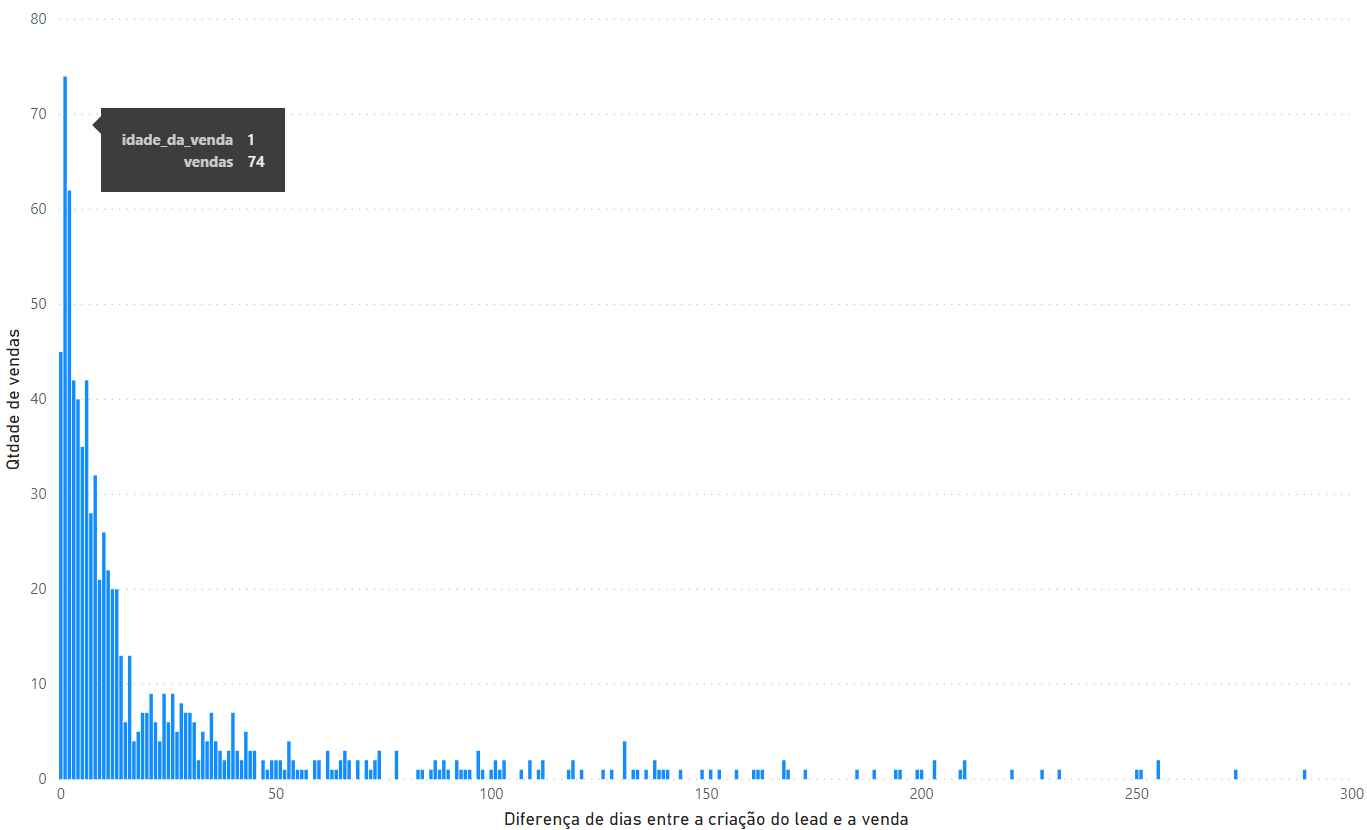

Podemos ver que a maior quantidade de vendas acontece 1 dia após a criação do lead e a quantidade de vendas cai drasticamente nos dias seguintes.

Após 100 dias, as vendas começam a ficar cada vez mais raras e o espaçamento entre os dias com venda aumenta.

Outro ponto que nos chama atenção é a diferença entre o dia 0 e o dia 1.

Com base na inspeção visual, podemos tentar ajustar um modelo linear do dia  0 até o dia 1, e um modelo exponencial negativo do dia 1 em diante:

In [7]:
def fit_exp(x, a, b):
    return a * np.exp(-b*x)


def fit_linear(x, a, b):
    return a + b*x

Criamos um novo modelo de dados para extração dos parâmetros:

In [8]:
model_data = df_idades_vendas_produtor.groupby('idade_da_venda', as_index=False)[['qtdade']].sum()
model_data.head()

idade_da_venda  qtdade
0               0      47
1               1      76
2               2      65
3               3      46
4               4      40

Os valores para os parâmetros das funções já foram objeto de experimentação prévia. As linhas abaixo reproduzem o código para extração inicial dos parâmetros a partir dos dados históricos:

In [9]:
x = model_data['idade_da_venda'].values
y = model_data['qtdade'].values

# popt, pcov = curve_fit(fit_exp, x, y, p0=[99.5, 0], bounds=(0, np.inf))
# popt, pcov = curve_fit(fit_linear, x, y, p0=[60, 0], bounds=(0, np.inf))

# curve_fit utiliza o métodos dos mínimos quadrados para minimização
## p0 define a melhor estimativa inicial para os coeficientes
## bounds restringe os valores dos coeficientes. No caso exponencial, já temos o sinal negativo na definição da função.
## popt retorna os valores para os coeficientes da função.
## pcov retorna a covariância entre x e y.

Com a exploração dos parâmetros já realizada, definimos:

In [10]:
exp_popt = np.array([99.55, 0.068])  # Valores dos parâmetros da função exponencial
exp_model_data = fit_exp(range(1, MIN_AGE + 1), *exp_popt)

linear_popt = np.array([60, 33]) # Valores dos parâmetros da função linear
linear_model_data = fit_linear(range(0, 2), *linear_popt)

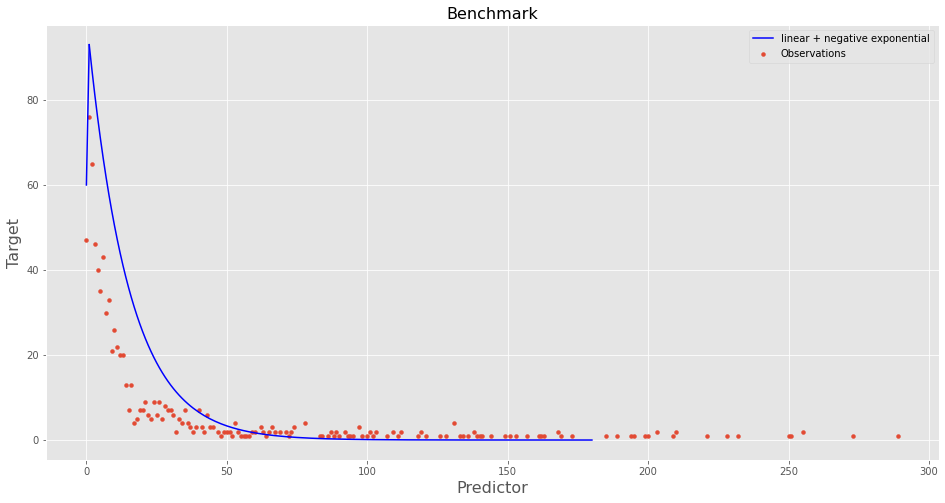

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(x, y, s=15, label='Observations')
plt.plot(range(1, MIN_AGE + 1), exp_model_data, color='b')
plt.plot(range(0, 2), linear_model_data, color='b', label='linear + negative exponential')
plt.xlabel('Predictor', fontsize=16)
plt.ylabel('Target', fontsize=16)
plt.legend()
plt.title('Benchmark', fontsize=16)
plt.show()

Podemos notar que o benchmark é agressivo e por vezes pode esperar o **dobro** da quantidade de vendas presentes nos dados históricos. 

Vamos testar algumas opções:

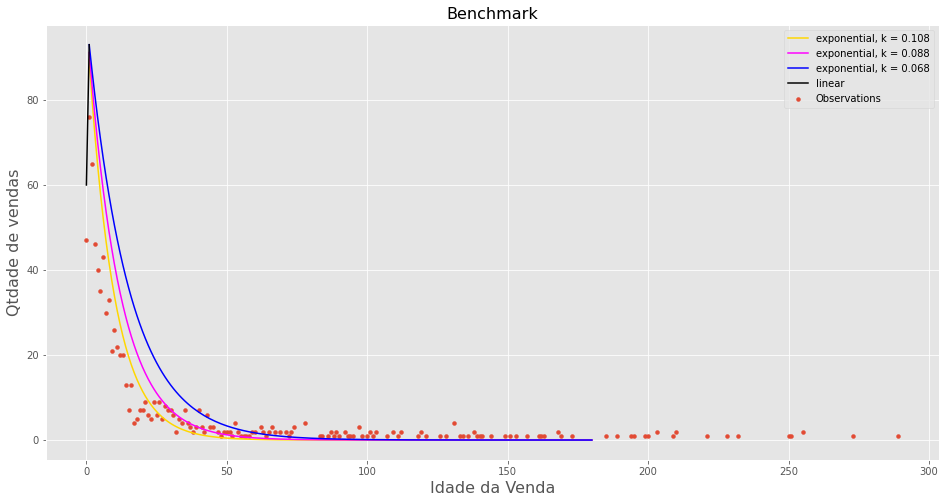

In [12]:
exp_k = [0.108, 0.088, 0.068]
colors = ['gold', 'fuchsia', 'b']
plt.figure(figsize=(16, 8))
plt.scatter(x, y, s=15, label='Observations')
for k, color in zip(exp_k, colors):
    exp_popt_test = np.array([99.55, k])  # Valores dos parâmetros da função exponencial
    exp_model_data = fit_exp(range(1, MIN_AGE + 1), *exp_popt_test)
    plt.plot(range(1, MIN_AGE + 1), exp_model_data, color=color, label='exponential, k = {}'.format(k))
plt.plot(range(0, 2), linear_model_data, color='k', label='linear')
plt.xlabel('Idade da Venda', fontsize=16)
plt.ylabel('Qtdade de vendas', fontsize=16)
plt.legend()
plt.title('Benchmark', fontsize=16)
plt.show()

In [13]:
vendas_benchmark = round(fit_exp(3, *exp_popt))
vendas_historicas = y[3]

No benchmark agressivo, temos **{{vendas_benchmark}}** vendas 3 dias após a criação do lead enquanto que os dados históricos apresentam **{{vendas_historicas}}**.

In [14]:
total_leads = df_total_leads['qtdade_leads'].values.take(0)
vendas_bench = []
for item in range(0,181):
    if item in [0, 1]:
        vendas_test = fit_linear(item, *linear_popt)        
    else:
        vendas_test = fit_exp(item, *exp_popt)
    vendas_bench.append(vendas_test)
expected_conversion = sum(vendas_bench) / total_leads
expected_conversion = '{:.1%}'.format(expected_conversion)

O benchmark aponta para uma conversão de **{{expected_conversion}}** após 180 dias.

## Cálculo da métrica de Conversão Diária

Precisamos de uma taxa de conversão para nosso modelo. Já temos a quantidade de vendas por dia e precisamos do total de leads:

In [15]:
total_leads = df_total_leads['qtdade_leads'].values.take(0)
total_leads

11189

Em seguida obtemos a taxa de conversão para cada dia no benchmark:

In [16]:
# Ajustamos o vetor de quantidade de vendas do benchmark concatenando os vetores do modelo linear e o exponencial.
exp_model_data = np.delete(exp_model_data, 0)
benchmark = np.concatenate([linear_model_data, exp_model_data])
benchmark_tx_conv = (benchmark / total_leads)
benchmark_tx_conv.take(range(0,10))

array([0.00536241, 0.00831173, 0.0077658 , 0.00725528, 0.00677832,
       0.00633271, 0.0059164 , 0.00552746, 0.00516409, 0.00482461])

A métrica será calculada com a seguinte lógica:
- Para cada taxa de conversão diária:
    - Subtraímos a taxa de conversão do benchmark da taxa de conversão do corretor:
    
    <p style="text-align: center;">$d_{i} = TxConvCorretor_{i} - TxConvBenchmark_{i}$</p>

Isso nos dará um vetor de diferenças, uma para cada dia. Logo:
- Se o valor for negativo, o corretor está abaixo do benchmark naquele dia
- Se o valor for positivo, o corretor está acima do benchmark naquele dia
- Se o valor for 0, o corretor está exatamente no benchmark naquele dia

Finalmente, fazemos a soma dos elementos do vetor para obtenção da métrica de Conversão Diária.
<p style="text-align: center;">$Conversão Diária = \sum_{i=0}^{n} d_i$</p>

In [17]:
scores = []

for broker in df.producer_id.unique():
    
    broker_df = df[df['producer_id'] == broker].copy()

    # se não fez nenhuma venda o score vai ser atribuido arbitrariamente em outra etapa
    if broker_df['qtdade'].sum() == 0:
        continue
    else:
        # tx de conversão do modelo
        broker_df['benchmark'] = benchmark_tx_conv

        # diferença entre a conversao do modelo e o corretor
        broker_tx_conv_diff = broker_df['tx_conv'] - broker_df['benchmark']

        # soma das diferenças.
        score = broker_tx_conv_diff.sum()
        scores.append(score)

scores_df = pd.DataFrame(data={'scores':scores})

Avaliamos somente os corretores com vendas.

In [18]:
scores_df.describe()

scores
count  147.000000
mean    -0.015391
std      0.131622
min     -0.125137
25%     -0.076934
50%     -0.048470
75%      0.011054
max      0.868197

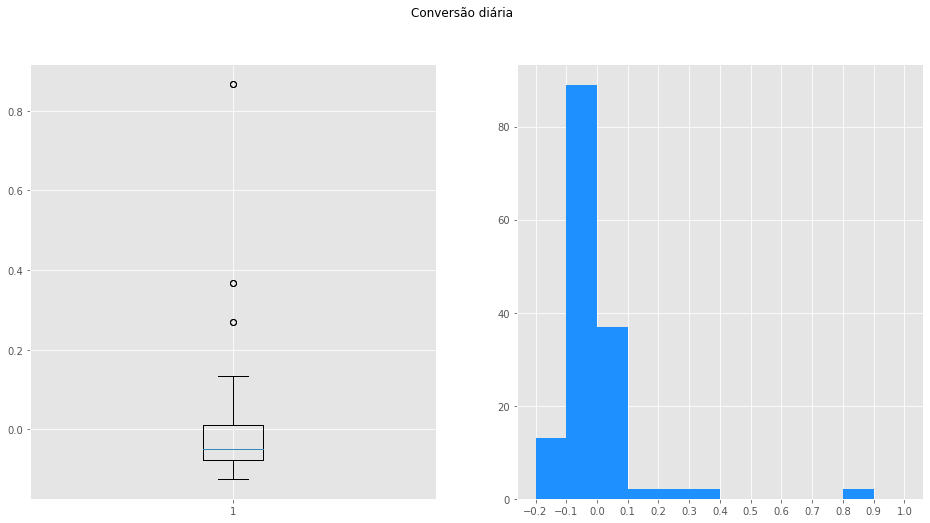

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
ax1.boxplot(scores)
ax2.hist(scores, color='dodgerblue', bins=np.arange(-0.2, 1.1, 0.1))
ax2.set_xticks(np.arange(-0.2, 1.1, 0.1))
fig.suptitle('Conversão diária')
plt.show()

O resultado nos mostra que 75% dos corretores têm Conversão Diária abaixo de **{{'{:.3}'.format(scores_df.describe()['scores']['75%'])}}**.

De forma a não penalizar os corretores sem venda, sugerimos o valor de **{{'{:.3}'.format(scores_df.describe()['scores']['50%'])}}** para a Conversão Diária do grupo sem venda. Esse valor é a mediana da Conversão Diária dos corretores com venda. A atualização periódica da Conversão Diária naturalmente irá incluir o corretor na lógica de cálculo a partir da primeira venda.